In [1]:
import os
import shutil

# Define the base path and destination path
base_path = "/Volumes/toby/BRATS2017/Brats17TrainingData/HGG"
destination_path = "/Volumes/toby/BRATS2017/TrainingDataset/images"

# Ensure the destination directory exists
os.makedirs(destination_path, exist_ok=True)

# Loop through the subfolders in the base path
for patient_folder in os.listdir(base_path):
    patient_path = os.path.join(base_path, patient_folder)
    
    # Check if it's a directory
    if os.path.isdir(patient_path):
        # Loop through the files in the patient folder
        for file_name in os.listdir(patient_path):
            if file_name.endswith("t1ce.nii"):
                # Construct full file path
                file_path = os.path.join(patient_path, file_name)
                
                # Copy the file to the destination folder
                shutil.copy(file_path, destination_path)
                print(f"Copied {file_name} to {destination_path}")

print("Finished copying t1ce.nii files.")


Copied Brats17_2013_10_1_t1ce.nii to /Volumes/toby/BRATS2017/TrainingDataset/images
Copied Brats17_2013_11_1_t1ce.nii to /Volumes/toby/BRATS2017/TrainingDataset/images
Copied Brats17_2013_12_1_t1ce.nii to /Volumes/toby/BRATS2017/TrainingDataset/images
Copied Brats17_2013_13_1_t1ce.nii to /Volumes/toby/BRATS2017/TrainingDataset/images
Copied Brats17_2013_14_1_t1ce.nii to /Volumes/toby/BRATS2017/TrainingDataset/images
Copied Brats17_2013_17_1_t1ce.nii to /Volumes/toby/BRATS2017/TrainingDataset/images
Copied Brats17_2013_18_1_t1ce.nii to /Volumes/toby/BRATS2017/TrainingDataset/images
Copied Brats17_2013_19_1_t1ce.nii to /Volumes/toby/BRATS2017/TrainingDataset/images
Copied Brats17_2013_20_1_t1ce.nii to /Volumes/toby/BRATS2017/TrainingDataset/images
Copied Brats17_2013_21_1_t1ce.nii to /Volumes/toby/BRATS2017/TrainingDataset/images
Copied Brats17_2013_22_1_t1ce.nii to /Volumes/toby/BRATS2017/TrainingDataset/images
Copied Brats17_2013_23_1_t1ce.nii to /Volumes/toby/BRATS2017/TrainingDataset

In [4]:
import os
import torch
from torch.utils.data import Dataset
import nibabel as nib
import numpy as np
import pandas as pd
import torchio as tio

In [11]:
class GBMdataset(Dataset):
    def __init__(self, image_dir, csv_path, target_dimensions=(128, 128, 128), target_spacing=(1, 1, 1), transform=None):
        """
        Args:
            image_dir (str): Directory with all the images.
            csv_path (str): Path to the CSV file containing patient metadata.
            target_dimensions (tuple): Desired output image dimensions (e.g., 128x128x128).
            target_spacing (tuple): Target voxel spacing for resampling (e.g., 1x1x1 mm).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.patient_data = self._load_patient_data(csv_path)
        self.patient_ids = list(self.patient_data.keys())
        self.target_dimensions = target_dimensions
        self.target_spacing = target_spacing

    def _load_patient_data(self, csv_path):
        data = pd.read_csv(csv_path)
        patient_data = {}
        for _, row in data.iterrows():
            patient_id = row['Brats17ID']
            age = row['Age']
            survival = row['Survival']
            patient_data[patient_id] = {'Age': age, 'Survival': survival}
        return patient_data
    
    def __len__(self):
        return len(self.patient_ids)
    
    def _resample_image(self, image_path):
        """Resample the image to the target voxel spacing using torchio."""
        image = tio.ScalarImage(image_path)
        resample_transform = tio.transforms.Resample(self.target_spacing)
        resampled_image = resample_transform(image)
        return resampled_image
    
    def _resize_image(self, image):
        """Resize the image to the target dimensions (e.g., 128x128x128)."""
        resize_transform = tio.transforms.Resize(self.target_dimensions)
        resized_image = resize_transform(image)
        return resized_image.data.numpy()
    
    def _normalize_image(self, image):
        """Normalize the image by subtracting mean and dividing by std."""
        mean = np.mean(image)
        std = np.std(image)
        if std == 0:  # To avoid division by zero
            std = 1.0
        return (image - mean) / std

    def __getitem__(self, idx):
        # Get the patient ID
        patient_id = self.patient_ids[idx]

        # Construct the file paths for the MRI images and segmentation
        t1_path = os.path.join(self.image_dir, f"{patient_id}_t1.nii")
        t1ce_path = os.path.join(self.image_dir, f"{patient_id}_t1ce.nii")
        flair_path = os.path.join(self.image_dir, f"{patient_id}_flair.nii")
        t2_path = os.path.join(self.image_dir, f"{patient_id}_t2.nii")
        seg_path = os.path.join(self.image_dir, f"{patient_id}_seg.nii")
        
        # Load and resample the images
        t1 = self._resample_image(t1_path)
        t1ce = self._resample_image(t1ce_path)
        flair = self._resample_image(flair_path)
        t2 = self._resample_image(t2_path)
        seg = self._resample_image(seg_path)

        # Resize the images to target dimensions (e.g., 128x128x128)
        t1 = self._resize_image(t1)
        t1ce = self._resize_image(t1ce)
        flair = self._resize_image(flair)
        t2 = self._resize_image(t2)
        seg = self._resize_image(seg)

        # Print the shape of the image after resampling and resizing
        #print(f"Image shape after resampling and resizing: {t1.shape}")
        
        # Normalize the images (for each modality)
        t1 = self._normalize_image(t1)
        t1ce = self._normalize_image(t1ce)
        flair = self._normalize_image(flair)
        t2 = self._normalize_image(t2)
        
        # Stack the images and segmentation into a single tensor
        image = np.stack([t1, t1ce, flair, t2, seg], axis=0)

        # Print the size of the image after resampling, resizing, and normalization
        #print(f"Image shape after resampling, resizing, and normalization: {image.shape}")
        
        # Get the survival time for this patient
        survival_time = self.patient_data[patient_id]['Survival']
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        # Convert image and survival time to torch tensors
        image = torch.tensor(image, dtype=torch.float32)
        survival_time = torch.tensor(survival_time, dtype=torch.float32)
        
        return image, survival_time


In [12]:
from torch.utils.data import DataLoader

# Define the directory with images and segmentation
image_dir = "/Volumes/toby/BRATS2017/TrainingDataset/images"

# Define the path to the CSV file containing the patient survival data
csv_path = "/Volumes/toby/BRATS2017/Brats17TrainingData/survival_data.csv"

# Create the dataset
dataset = GBMdataset(image_dir=image_dir, csv_path=csv_path)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

# Example loop over the data
for batch_idx, (images, survival_times) in enumerate(dataloader):
    if batch_idx < 2:  # Only print for the first 2 batches
        print(f"Batch {batch_idx + 1}")
        print(f"Images shape: {images.shape}")
        print(f"Survival times: {survival_times}")
    else:
        break  # Exit the loop after the first 2 batches


Image shape after resampling and resizing: (1, 128, 128, 128)
Image shape after resampling, resizing, and normalization: (5, 1, 128, 128, 128)
Image shape after resampling and resizing: (1, 128, 128, 128)
Image shape after resampling and resizing: (1, 128, 128, 128)
Image shape after resampling, resizing, and normalization: (5, 1, 128, 128, 128)
Image shape after resampling and resizing: (1, 128, 128, 128)
Image shape after resampling, resizing, and normalization: (5, 1, 128, 128, 128)
Image shape after resampling, resizing, and normalization: (5, 1, 128, 128, 128)
Image shape after resampling and resizing: (1, 128, 128, 128)
Image shape after resampling, resizing, and normalization: (5, 1, 128, 128, 128)
Image shape after resampling and resizing: (1, 128, 128, 128)
Image shape after resampling and resizing: (1, 128, 128, 128)
Image shape after resampling, resizing, and normalization: (5, 1, 128, 128, 128)
Image shape after resampling, resizing, and normalization: (5, 1, 128, 128, 128)

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

def addnoise(input_tensor, noise_factor = 0.3):
    inputs = input_tensor
    noise = inputs + torch.rand_like(inputs) * noise_factor
    noise = torch.clip (noise,0,1.)
    return noise

class GaussianNoise(nn.Module):
    def __init__(self, noise_factor=0.3):
        super(GaussianNoise, self).__init__()
        self.noise_factor = noise_factor

    def forward(self, input_tensor):
        if self.training:  
            noise = input_tensor + torch.rand_like(input_tensor) * self.noise_factor
            noise = torch.clip(noise, 0, 1.0)
            return noise
        return input_tensor 

        

class encoder(nn.Module):
    def __init__(self, input_shape, network_depth, no_convolutions, conv_filter_no_init, 
                 conv_kernel_size, latent_representation_dim, l1, l2, dropout_value, 
                 use_batch_normalization, activation, gaussian_noise_factor=0.3):
        super(encoder, self).__init__()
        self.input_shape = input_shape
        self.network_depth = network_depth
        self.no_convolutions = no_convolutions
        self.conv_filter_no_init = conv_filter_no_init
        self.conv_kernel_size = conv_kernel_size
        self.latent_representation_dim = latent_representation_dim
        self.l1 = l1
        self.l2 = l2
        self.dropout_value = dropout_value
        self.use_batch_normalization = use_batch_normalization
        self.activation = activation  
        self.encoder_layers = nn.ModuleList()
        self.gaussian_noise_factor = gaussian_noise_factor
        # Gaussian noise layer
        if gaussian_noise_factor:
            self.noise_layer = GaussianNoise()
        else:
            self.noise_layer = None

        # Convolutional layers
        in_channels = self.input_shape[0]
        for i in range(network_depth):
            for j in range(no_convolutions):
                out_channels = self.conv_filter_no_init * (2 ** i)
                conv_layer = nn.Conv3d(in_channels, out_channels, self.conv_kernel_size, padding=conv_kernel_size // 2)
                self.encoder_layers.append(conv_layer)
                if self.use_batch_normalization:
                    self.encoder_layers.append(nn.BatchNorm3d(out_channels))
                if self.activation == 'leakyrelu':
                    self.encoder_layers.append(nn.LeakyReLU(inplace=True))
                else:
                    self.encoder_layers.append(nn.ReLU(inplace=True))
                in_channels = out_channels
            self.encoder_layers.append(nn.MaxPool3d(kernel_size=2, stride=2))
            if dropout_value:
                self.encoder_layers.append(nn.Dropout3d(p=dropout_value))

        self.flatten = nn.Flatten()

        # Calculate feature map size after convolution
        with torch.no_grad():
            dummy_input = torch.zeros(1, *self.input_shape)
            conv_output = self._forward_conv_layers(dummy_input)
            self.feature_map_size = conv_output.size()
            flattened_dim = conv_output.view(1, -1).size(1)

        # Fully connected layer
        self.fc = nn.Linear(flattened_dim, latent_representation_dim)
        if activation == 'leakyrelu':
            self.activation_fn = nn.LeakyReLU(inplace=True)
        else:
            self.activation_fn = nn.ReLU(inplace=True)
            
    def _forward_conv_layers(self, x):
        if self.noise_layer:
            x = self.noise_layer(x)
        for layer in self.encoder_layers:
            x = layer(x)
        return x
    
    def forward(self, x):
        x = self._forward_conv_layers(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.activation_fn(x)
        return x



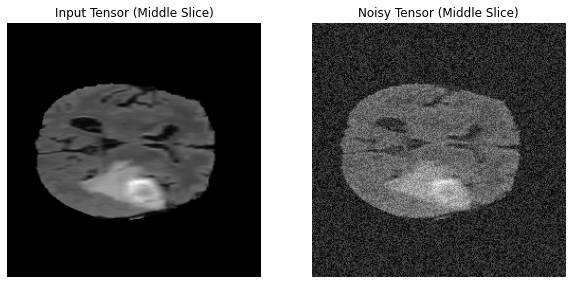

In [82]:
import nibabel as nib
import torch
import matplotlib.pyplot as plt

# Define the addnoise function
def addnoise(input_tensor, noise_factor=0.3):
    noise = input_tensor + torch.rand_like(input_tensor) * noise_factor
    noise = torch.clip(noise, 0, 1.0)
    return noise

# Load the .nii image using nibabel
path = "/Volumes/toby/Task01_BrainTumour/imagesTr/BRATS_001.nii.gz"
nii_image = nib.load(path)

# Get the data from the NIfTI file and convert to PyTorch tensor
image_data = nii_image.get_fdata()  # Extract image data as a NumPy array
input_tensor = torch.tensor(image_data, dtype=torch.float32)  # Convert to PyTorch tensor

# Normalize the tensor for visualization
input_tensor = (input_tensor - input_tensor.min()) / (input_tensor.max() - input_tensor.min())

# Apply noise to the image
output_tensor = addnoise(input_tensor)
output_tensor = output_tensor[..., 0]  # Select the first slice along the last dimension
input_tensor = input_tensor[..., 0]  # Select the first slice along the last dimension

# Visualize the selected 2D slice (middle slice)
slice_idx = output_tensor.shape[-1] // 2  # Middle slice for visualization

# Create subplots for the input and output tensors (2 subplots)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # Create 2 subplots side by side

# Input tensor visualization (middle slice)
ax[0].imshow(input_tensor[..., slice_idx], cmap='gray')
ax[0].set_title("Input Tensor (Middle Slice)")
ax[0].axis('off')

# Output tensor visualization (Noisy, middle slice)
ax[1].imshow(output_tensor[..., slice_idx], cmap='gray')
ax[1].set_title("Noisy Tensor (Middle Slice)")
ax[1].axis('off')

# Show the plots
plt.show()


In [84]:
# Example usage
input_shape = (5, 128, 128, 128)  # 5 channels, 128x128x128 spatial dimensions
network_depth = 4
no_convolutions = 2
conv_filter_no_init = 32
conv_kernel_size = 3
latent_representation_dim = 128
l1 = 0.01
l2 = 0.01
dropout_value = 0.5
use_batch_normalization = True
activation = 'leakyrelu'

# Instantiating the encoder
encoder_model = encoder(
    input_shape=input_shape,
    network_depth=network_depth,
    no_convolutions=no_convolutions,
    conv_filter_no_init=conv_filter_no_init,
    conv_kernel_size=conv_kernel_size,
    latent_representation_dim=latent_representation_dim,
    l1=l1,
    l2=l2,
    dropout_value=dropout_value,
    use_batch_normalization=use_batch_normalization,
    activation=activation,
    gaussian_noise_factor = 0.3
)

# Generating random input data (Batch size 1, input shape as defined above)
input_data = torch.randn(1, *input_shape)

# Forward pass (calling forward without any keyword arguments)
output = encoder_model(input_data)

# Output the latent representation
print(output)


tensor([[ 1.5174e+00,  3.5516e-01,  1.0483e+00, -5.3858e-05, -1.5182e-02,
         -2.2228e-03, -3.1634e-03, -1.4061e-02, -1.7340e-02,  1.3951e-01,
          9.2359e-01,  8.2124e-01,  1.3044e+00, -9.7913e-03, -8.5220e-03,
         -1.7867e-03,  1.8585e+00,  1.0275e+00, -2.8374e-02, -1.6976e-02,
         -6.1185e-03,  1.8987e-01,  1.6319e-01,  1.4393e+00,  1.0598e+00,
         -4.8188e-03,  7.7611e-01,  1.4606e-01,  1.7014e+00, -2.1494e-03,
         -7.8358e-03,  3.1321e-01, -7.5873e-03, -3.4291e-03, -3.2107e-02,
         -1.1904e-02,  2.6295e-01,  1.8799e+00,  1.8189e-01, -3.5094e-03,
          1.1845e-01,  7.7927e-01, -6.8809e-03,  3.2673e-01, -2.7036e-02,
          8.1007e-02, -1.4422e-02,  8.2568e-01, -3.5537e-03,  1.7976e+00,
         -1.3333e-02,  1.3015e+00, -5.9352e-03,  1.2685e+00, -1.5115e-02,
          3.6978e-01, -7.3173e-03, -8.2925e-03,  1.0169e+00, -7.5506e-04,
          6.0862e-01,  2.2670e+00, -1.2531e-02,  3.2300e-01,  1.3163e+00,
          1.2173e+00, -1.6651e-02,  1.

In [85]:
import torch
import torch.nn as nn
import numpy as np

def downsample_fn(depth):
    if depth == 4:
        return [(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)]  # Increase depth upsample factor to 2
    elif depth == 2:
        return [(4, 4, 4), (4, 4, 4)]  # Increase depth upsample factor to 4 if needed
    else:
        raise ValueError(f'Unsupported depth: {depth}')
    
class Decoder3D(nn.Module):
    def __init__(self, conv_shape, network_depth, no_convolutions, conv_filter_no_init,
                 conv_kernel_size, latent_representation_dim, output_channels=5, l1=0.0, l2=0.0,
                 dropout_value=0.0, use_batch_normalization=False, activation='relu'):
        super(Decoder3D, self).__init__()
        self.conv_shape = conv_shape  # Shape of the feature map at the start of the decoder
        self.network_depth = network_depth
        self.no_convolutions = no_convolutions
        self.conv_filter_no_init = conv_filter_no_init
        self.conv_kernel_size = conv_kernel_size
        self.latent_representation_dim = latent_representation_dim
        self.l1 = l1
        self.l2 = l2
        self.dropout_value = dropout_value
        self.use_batch_normalization = use_batch_normalization
        self.activation = activation
        self.output_channels = output_channels  # Final output channels (e.g., 5 channels for MRI modalities)
        
        # Activation function
        if activation == 'leakyrelu':
            self.activation_fn = nn.LeakyReLU(inplace=True)
        else:
            self.activation_fn = nn.ReLU(inplace=True)

        # Fully connected layer to reshape the latent vector into a 3D shape
        self.fc = nn.Linear(latent_representation_dim, np.prod(self.conv_shape))

        # Reshape layer to convert the flat output of the FC layer into a 3D volume
        self.reshape = lambda x: x.view(-1, *self.conv_shape)
        
        # Decoder layers (upsample and conv layers)
        self.decoder_layers = nn.ModuleList()
        
        # Reverse the depth, so we progressively upsample back to the original image size
        in_channels = conv_shape[0]  # Start with the number of channels from the conv_shape
        for i in reversed(range(network_depth)):
            # Upsampling layer
            upsample_factors = downsample_fn(network_depth)[i]
            self.decoder_layers.append(nn.Upsample(scale_factor=upsample_factors, mode='trilinear', align_corners=False))
            
            # Convolution layers
            out_channels = self.conv_filter_no_init * (2 ** i)  # Reduce the number of channels as we move up the network
            for j in range(no_convolutions):
                print(f"Layer {i}-{j}: in_channels = {in_channels}, out_channels = {out_channels}")
                self.decoder_layers.append(nn.Conv3d(in_channels, out_channels, kernel_size=conv_kernel_size, padding=1))
                if use_batch_normalization:
                    self.decoder_layers.append(nn.BatchNorm3d(out_channels))
                if activation == 'leakyrelu':
                    self.decoder_layers.append(nn.LeakyReLU(inplace=True))
                else:
                    self.decoder_layers.append(nn.ReLU(inplace=True))
                in_channels = out_channels  # Update in_channels for the next layer
            if dropout_value > 0.0:
                self.decoder_layers.append(nn.Dropout3d(p=dropout_value))
        
        # Final convolution to produce the reconstructed image with the correct number of output channels
        print(f"Final Layer: in_channels = {in_channels}, out_channels = {self.output_channels}")
        self.final_conv = nn.Conv3d(in_channels, self.output_channels, conv_kernel_size, padding=1)
        self.final_activation = nn.ReLU()  # You could change this to `nn.Sigmoid()` or `nn.Tanh()` depending on the data range

    def forward(self, x):
        # Expand the latent vector via the fully connected layer
        x = self.fc(x)
        x = self.activation_fn(x)
        
        # Reshape to the shape required for the convolutional layers
        x = self.reshape(x)  # Reshape to 3D tensor (batch_size, channels, depth, height, width)
        
        # Apply the decoder layers
        for layer in self.decoder_layers:
            x = layer(x)
        
        # Final convolution to produce the output volume
        x = self.final_conv(x)
        x = self.final_activation(x)
        return x

# Example usage
latent_vector = torch.randn(1, 128)  # Latent vector of size [batch_size, latent_representation_dim]
conv_shape = (256, 8, 8, 8)  # Example shape of the feature map before the decoder
decoder_model = Decoder3D(conv_shape=conv_shape, network_depth=4, no_convolutions=2, 
                          conv_filter_no_init=64, conv_kernel_size=3, 
                          latent_representation_dim=128)

output_image = decoder_model(latent_vector)
print("Decoder output shape:", output_image.shape)  # Should be [batch_size, 5, 240, 240, 150] or similar


Layer 3-0: in_channels = 256, out_channels = 512
Layer 3-1: in_channels = 512, out_channels = 512
Layer 2-0: in_channels = 512, out_channels = 256
Layer 2-1: in_channels = 256, out_channels = 256
Layer 1-0: in_channels = 256, out_channels = 128
Layer 1-1: in_channels = 128, out_channels = 128
Layer 0-0: in_channels = 128, out_channels = 64
Layer 0-1: in_channels = 64, out_channels = 64
Final Layer: in_channels = 64, out_channels = 5
Decoder output shape: torch.Size([1, 5, 128, 128, 128])


In [86]:
class LatentParametersModel(nn.Module):
    def __init__(self, latent_representation_dim, l1=0.0, l2=0.0):
        super(LatentParametersModel, self).__init__()
        self.mu_sigma_layer = nn.Linear(
            in_features=latent_representation_dim, 
            out_features=2
        )
        nn.init.xavier_uniform_(self.mu_sigma_layer.weight)
        nn.init.zeros_(self.mu_sigma_layer.bias)
        self.l1 = l1
        self.l2 = l2
    
    def forward(self, x):
        mu_sigma = self.mu_sigma_layer(x)
        return mu_sigma
    



In [87]:
latent_representation_dim = 128  # Example latent representation dimension
model = LatentParametersModel(latent_representation_dim=latent_representation_dim)

# Simulate an input from the encoder
x = torch.randn((1, latent_representation_dim))  # Batch size of 1, with 128-dimensional latent vector
mu_sigma = model(x)

print("Predicted mu and sigma:", mu_sigma)

Predicted mu and sigma: tensor([[-1.9138, -1.3826]], grad_fn=<AddmmBackward0>)


In [101]:
def reconstruction_loss(y_true, y_pred):
    mse_loss = F.mse_loss(y_pred, y_true, reduction='none')
    reduced_loss = mse_loss.mean(dim=[1, 2, 3])
    return reduced_loss

import torch

def survival_loss(mu, sigma, x, delta):
    """
    Custom loss function based on the negative log-likelihood.

    :param mu: Predicted mean (log of hazard ratio), tensor of shape (batch_size,)
    :param sigma: Predicted standard deviation (scale parameter), tensor of shape (batch_size,)
    :param x: Observed time (log-transformed), tensor of shape (batch_size,)
    :param delta: Event indicator (1 if event occurred, 0 if censored), tensor of shape (batch_size,)
    :return: Computed loss, scalar value
    """
    # Negative log-likelihood term
    total_loss = -(torch.log(x)-mu)/sigma.sum()+(delta * torch.log(sigma) + (1 + delta) * torch.log(1 + torch.exp((torch.log(x)-mu)/sigma)))
    
    # Return the mean loss across the batch
    return total_loss / x.size(0)

# Example usage
mu = torch.tensor([0.5, 0.8, 0.3])  # Predicted means (log hazard ratios)
sigma = torch.tensor([1.1, 1.2, 1.1])  # Predicted standard deviations (not log-transformed)
x = torch.tensor([1.0, 0.8, 0.9])  # Log-transformed observed times
delta = torch.tensor([1.0, 0.0, 1.0])  # Event indicators

loss = survival_loss(mu, sigma, x, delta)
print(loss)


tensor([0.4084, 0.2187, 0.4220])


In [24]:
import torch.optim as optim

In [97]:

class GlioNet(nn.Module):
    def __init__(self, encoder, decoder, latent_param_model):
        super(GlioNet, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_param_model = latent_param_model

    def forward(self, x):
        latent_representation = self.encoder(x)
        reconstruction = self.decoder(latent_representation)
        latent_params = self.latent_param_model(latent_representation)
        return reconstruction, latent_params
    
def compile_all_models(input_shape,
                        network_depth,
                        no_convolutions,
                        conv_filter_no_init,
                        conv_kernel_size,
                        latent_representation_dim,
                        dropout_value,
                        use_batch_normalization,
                        activation,
                        l1,
                        l2,
                        lr=1e-3):
    
    encoder_model = encoder(
        input_shape=input_shape,
        network_depth=network_depth,
        no_convolutions=no_convolutions,
        conv_filter_no_init=conv_filter_no_init,
        conv_kernel_size=conv_kernel_size,
        latent_representation_dim=latent_representation_dim,
        l1=l1,
        l2=l2,
        dropout_value=dropout_value,
        use_batch_normalization=use_batch_normalization,
        activation=activation,
        gaussian_noise_factor = 0.3
    )

    conv_shape = encoder_model.feature_map_size[1:]
    decoder_model = Decoder3D(
        conv_shape=conv_shape,
        network_depth=network_depth,
        no_convolutions=no_convolutions,
        conv_filter_no_init=conv_filter_no_init,
        conv_kernel_size=conv_kernel_size,
        latent_representation_dim=latent_representation_dim,
        dropout_value=dropout_value,
        use_batch_normalization=use_batch_normalization,
        activation=activation
    )

    latent_param_model = LatentParametersModel(
        latent_representation_dim=latent_representation_dim,
        l1=l1,
        l2=l2
    )

    model = GlioNet(encoder_model, decoder_model, latent_param_model)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    return model, optimizer




    

    




In [98]:
def compute_combined_loss(reconstruction, target, latent_params, x, 
                          reconstruction_loss_fn, survival_loss_fn, delta=1):
    
    mu, sigma = latent_params[:, 0], latent_params[:, 1]
    reconstruction_loss = reconstruction_loss_fn(target, reconstruction)
    survival_loss = survival_loss_fn(mu, sigma, x, delta)
    total_loss = reconstruction_loss.mean() + survival_loss.mean()
    return total_loss, reconstruction_loss.mean(), survival_loss.mean()



In [100]:
input_shape = (1, 64, 64, 64)  # Example shape
network_depth = 4
no_convolutions = 2
conv_filter_no_init = 16
conv_kernel_size = 3
latent_representation_dim = 128
dropout_value = 0.3
use_batch_normalization = True
activation = 'relu'
l1 = 0.0
l2 = 0.0
lr = 1e-3

# Compile the model
model, optimizer = compile_all_models(
    input_shape=input_shape,
    network_depth=network_depth,
    no_convolutions=no_convolutions,
    conv_filter_no_init=conv_filter_no_init,
    conv_kernel_size=conv_kernel_size,
    latent_representation_dim=latent_representation_dim,
    dropout_value=dropout_value,
    use_batch_normalization=use_batch_normalization,
    activation=activation,
    l1=l1,
    l2=l2,
    lr=lr
)

# Example input for forward pass
input_data = torch.randn(1, *input_shape)  # Example input

# Forward pass
reconstruction, latent_params = model(input_data)
print("Reconstruction shape:", reconstruction.shape)
print("Latent parameters:", latent_params)




Layer 3-0: in_channels = 128, out_channels = 128
Layer 3-1: in_channels = 128, out_channels = 128
Layer 2-0: in_channels = 128, out_channels = 64
Layer 2-1: in_channels = 64, out_channels = 64
Layer 1-0: in_channels = 64, out_channels = 32
Layer 1-1: in_channels = 32, out_channels = 32
Layer 0-0: in_channels = 32, out_channels = 16
Layer 0-1: in_channels = 16, out_channels = 16
Final Layer: in_channels = 16, out_channels = 5
Reconstruction shape: torch.Size([1, 5, 64, 64, 64])
Latent parameters: tensor([[ 0.0689, -0.1915]], grad_fn=<AddmmBackward0>)


In [106]:
def model_fn(config):
    model, optimizer = compile_all_models(
        input_shape=config["input_shape"],
        network_depth=config["network_depth"],
        no_convolutions=config["no_convolutions"],
        conv_filter_no_init=config["conv_filter_no_init"],
        conv_kernel_size=config["conv_kernel_size"],
        latent_representation_dim=config["latent_representation_dim"],
        dropout_value=config["dropout_value"],
        use_batch_normalization=config["use_batch_normalization"],
        activation=config["activation"],
        l1=0.0,
        l2=0.0,
        lr=config["lr"]
    )
    return model, optimizer

def train_model(config, optimizer, train_loader, compute_combined_loss, device="cpu"):
    model = model.to(device)
    model.train()
    epochs = config["epochs"]
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, survival_times) in enumerate(train_loader):
            inputs = inputs.to(device)
            survival_times = survival_times.to(device)
            delta = torch.ones_like(survival_times).to(device)
            optimizer.zero_grad()
            model,optimizer = model_fn(config)
            reconstruction, latent_params = model(inputs)
            total_loss, rec_loss, surv_loss = compute_combined_loss(
                reconstruction, inputs, latent_params, survival_times,
                reconstruction_loss, survival_loss, delta
            )
            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Total Loss: {running_loss/len(train_loader):.4f}")

    print("Training Finished!")






In [107]:
from ray import train
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search import BasicVariantGenerator

search_space = {
    "input_shape": (5, 128, 128, 128),  # Fixed for all searches
    "network_depth": tune.choice([2, 3, 4, 5]),
    "no_convolutions": tune.choice([1, 2, 3]),
    "conv_filter_no_init": tune.choice([8, 16, 32, 64]),
    "conv_kernel_size": tune.choice([3, 5]),
    "latent_representation_dim": tune.choice([64, 128, 256]),
    "dropout_value": tune.uniform(0.2, 0.4),
    "use_batch_normalization": tune.choice([True, False]),
    "activation": tune.choice(["relu", "leakyrelu"]),
    "lr": tune.loguniform(1e-4, 1e-3),
    "epochs": tune.choice([10, 20, 30])
}

def run_hyperparameter_search():
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=30, 
        grace_period=1,
        reduction_factor=2
    )

    analysis = tune.run(
        train_model, 
        config=search_space, 
        num_samples=10,  
        scheduler=scheduler,  
        resources_per_trial={"cpu": 1, "gpu": 1 if torch.cuda.is_available() else 0} 
    )

    print("Best hyperparameters found were: ", analysis.best_config)

In [ ]:
import ray
if __name__ == "__main__":
    ray.init()
    run_hyperparameter_search()